In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('D:/stat_team/project/beers-breweries-and-beer-reviews/reviews.csv')
df.head()

,beer_id,username,date,text,look,smell,taste,feel,overall,score
0,271781,bluejacket74,2017-03-17,"750 ml bottle, 2016 vintage, bottle #304 of...",4.00,4.00,4.00,4.25,4.00,4.03
1,125646,_dirty_,2017-12-21,,4.50,4.50,4.50,4.50,4.50,4.50
2,125646,CJDUBYA,2017-12-21,,4.75,4.75,4.75,4.75,4.75,4.75
3,125646,GratefulBeerGuy,2017-12-20,0% 16 oz can. Funny story: As I finally wal...,4.75,4.75,4.50,4.50,4.50,4.58
4,125646,LukeGude,2017-12-20,Classic TH NEIPA. Overflowing head and bouq...,4.25,4.50,4.25,4.25,4.25,4.31


In [3]:
#잠깐 전처리

cols = ['beer_id','username','score']
df = df[cols]
df.rename(columns = {'beer_id':'beerid','username':'userid','score':'rating'}, inplace = True)
df.head()

,beerid,userid,rating
0,271781,bluejacket74,4.03
1,125646,_dirty_,4.50
2,125646,CJDUBYA,4.75
3,125646,GratefulBeerGuy,4.58
4,125646,LukeGude,4.31


In [4]:
#딥러닝에 이용할 컬럼 변경: user, beer, rating

user_enc = LabelEncoder()
df['user'] = user_enc.fit_transform(df['userid'].tolist())
n_users = df['user'].nunique()

item_enc = LabelEncoder()
df['beer'] = item_enc.fit_transform(df['beerid'].values)
n_beers = df['beer'].nunique()

df['rating'] = df['rating'].values.astype(np.float32)
min_rating = min(df['rating'])
max_rating = max(df['rating'])

n_users, n_beers, min_rating, max_rating #n_users, n_beers: 유니크한 값 개수, rating의 최솟값과 최댓값.

(164935, 309542, 1.0, 5.0)

In [5]:
df2=df[['user','beer','rating']] 
df2.head() #완료된 데이터셋. 여기서 'user','beer','rating'만 사용

,user,beer,rating
0,102213,231507,4.03
1,94429,112229,4.50
2,15635,112229,4.75
3,34826,112229,4.58
4,55007,112229,4.31


In [6]:
#train, test 셋 분할: test size는 0.2, random_state는 임의로 지정
X = df[['user', 'beer']].values
y = df['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7258502, 2), (1814626, 2), (7258502,), (1814626,))

In [7]:
#딥러닝 모델을 만들 때 필요한 또다른 변수는: 잠재요인의 개수를 정하는 것!
#잠재요인의 개수는 원하는 대로 설정하면 되지만, 주의할 것은 user와 beer 모두에 대해 같은 사이즈를 줘야 한다는 점.

#우리는 50개로 간다!(X에 대해서만 적용)
n_factors = 50

#X를 array로 만들기
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [52]:
beers = pd.read_csv('D:/stat_team/project/beers-breweries-and-beer-reviews/beers.csv')

## create a dictionary out of beerid, beer original title
beers_dict = beers.set_index('id')['name'].to_dict()

In [8]:
#keras 라이브러리 로드
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers import Embedding, Flatten, Dense, Dropout, concatenate, multiply, Input
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Add, Activation, Lambda, Concatenate

Using TensorFlow backend.


In [9]:
##시각화(각 epoch마다의 MSE, MAE 값 비교)

def plot_history(hist):
    
    plt.figure(figsize=(10,15))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [rating]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],label = 'Test Error')
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$rating^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],label = 'Test Error')
    plt.legend()
    plt.show()


# 옵티마이저 Adam / tanh->relu / batch_size = 1000 / epoch = 10

In [26]:
#원래 함수(수정본2)
##bias가 있음, 아주 단순한 버전. 그냥 R_hat = u*m으로 연산한다. 최저 rating과 최고 rating을 이용한다.
##layer 2개를 추가하였고, activation 함수 2개는: relu와 sigmoid

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal')(x) 
        x = Reshape((self.n_factors,))(x)
        return x

def RecommenderV5_1(n_users, n_beers, n_factors):
    
    #input: user, beer
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user) #u는 user * n_factor
    ub = EmbeddingLayer(n_users, 1)(user) #user_bias
    
    beer = Input(shape=(1,))
    b = EmbeddingLayer(n_beers, n_factors)(beer) #b은 beer * n_factor
    bb = EmbeddingLayer(n_beers, 1)(beer) #beer_bias
    
    #input 연산- activation 2가지를 추가. tanh과 relu
    x = Concatenate()([u, b])
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('tanh')(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)


    #최종 모델 만들기(input은 user, beer 2개를 받고, output은 x를 반환.)
    model = Model(inputs=[user, beer], outputs=x)
    opt = Adam(lr=0.001) #learning rate(학습률) 설정. #optimizer인 최적화 방법은 Adam을 씀.
    model.compile(loss=['mse'], metrics = ['mae','mse'] ,optimizer=opt) #loss와 함께 출력할 mae, mse는 metrics로 설정.

    return model

In [27]:
re5model_1 = RecommenderV5_1(n_users, n_beers, n_factors)
re5model_1.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 1, 50)        8246750     input_7[0][0]                    
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 1, 50)        15477100    input_8[0][0]                    
____________________________________________________________________________________________

In [ ]:
## fit model
import numpy as np
seed = 7
np.random.seed(seed)
history_mf5_1 = re5model_1.fit(x=X_train_array, y=y_train, batch_size=1000, epochs=10,
                    verbose=1, validation_data=(X_test_array, y_test)) 

Train on 7258502 samples, validate on 1814626 samples
Epoch 1/10
7258502/7258502 [==============================] - 4433s 611us/step - loss: 0.2316 - mae: 0.3324 - mse: 0.2316 - val_loss: 0.1838 - val_mae: 0.3036 - val_mse: 0.1838
Epoch 2/10
7258502/7258502 [==============================] - 4781s 659us/step - loss: 0.1737 - mae: 0.2942 - mse: 0.1737 - val_loss: 0.1785 - val_mae: 0.2989 - val_mse: 0.1785
Epoch 3/10
7258502/7258502 [==============================] - 4354s 600us/step - loss: 0.1646 - mae: 0.2855 - mse: 0.1646 - val_loss: 0.1766 - val_mae: 0.2941 - val_mse: 0.1766
Epoch 4/10
7258502/7258502 [==============================] - 4062s 560us/step - loss: 0.1578 - mae: 0.2789 - mse: 0.1578 - val_loss: 0.1767 - val_mae: 0.2959 - val_mse: 0.1767
Epoch 5/10
7258502/7258502 [==============================] - 4060s 559us/step - loss: 0.1516 - mae: 0.2731 - mse: 0.1516 - val_loss: 0.1774 - val_mae: 0.2966 - val_mse: 0.1774
Epoch 6/10
7258502/7258502 [==============================] -

In [29]:
## show loss & mae & mse at each epoch
hist5_1 = pd.DataFrame(history_mf5_1.history)
hist5_1['epoch'] = history_mf5_1.epoch
hist5_1

,val_loss,val_mae,val_mse,loss,mae,mse,epoch
0,0.183785,0.303635,0.183784,0.231564,0.332360,0.231563,0
1,0.178545,0.298941,0.178545,0.173659,0.294210,0.173659,1
2,0.176583,0.294141,0.176583,0.164562,0.285464,0.164562,2
3,0.176681,0.295940,0.176681,0.157807,0.278924,0.157807,3
4,0.177378,0.296558,0.177378,0.151592,0.273080,0.151592,4
5,0.178530,0.296585,0.178530,0.145783,0.267503,0.145783,5
6,0.179940,0.299311,0.179941,0.140834,0.262758,0.140834,6
7,0.181439,0.299128,0.181439,0.136851,0.258804,0.136851,7
8,0.182640,0.300811,0.182640,0.133521,0.255483,0.133521,8
9,0.183617,0.302124,0.183617,0.130816,0.252755,0.130816,9


In [30]:
#모델 평가하기; model.evaluate() #test set에 평가했을 때, 맨 마지막 epoch의 val_loss, val_mae, val_mse
loss_and_metrics_1 = re5model_1.evaluate(X_test_array, y_test, batch_size=1000)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics_1)

1814626/1814626 [==============================] - 3s 2us/step
## evaluation loss and_metrics ##
[0.18361665110496375, 0.30212438106536865, 0.18361686170101166]


In [31]:
## get weights of the beers embedding matrix
beer_embedding_weights_1 = re5model_1.layers[3].get_weights()[0] #3은 beer-embedding : layer 확인!
beer_embedding_weights_1.shape

(309542, 50)

In [32]:
## import PCA
from sklearn.decomposition import PCA

pca = PCA(n_components = 3) ## use 3 components
beer_embedding_weights_t_1 = np.transpose(beer_embedding_weights_1) ## pass the transpose of the embedding matrix
beer_pca_1 = pca.fit(beer_embedding_weights_t_1) ## fit

## display the resulting matrix dimensions
beer_pca_1.components_.shape

(3, 309542)

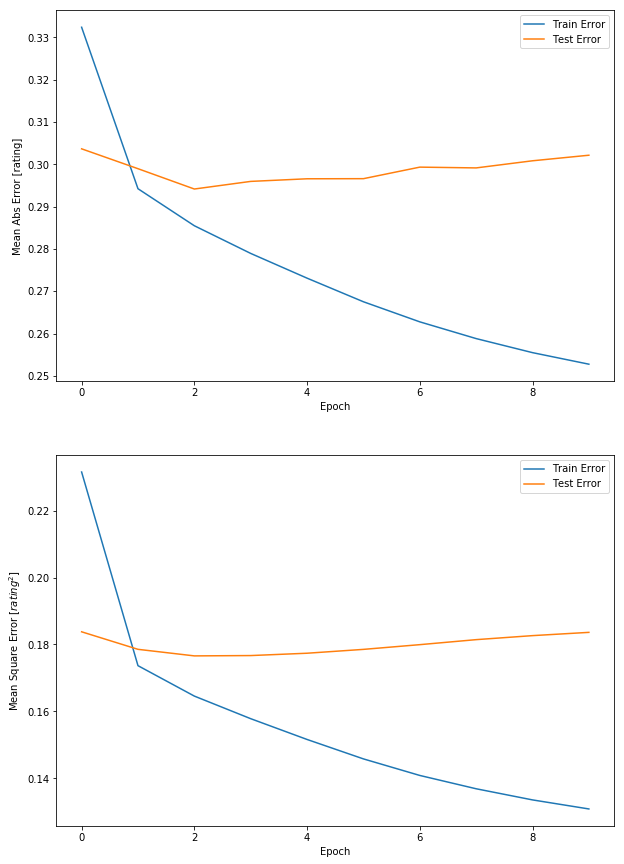

In [33]:
plot_history(hist5_1)

In [56]:
%%time

unbeers = get_unbeer_keras(df2, 190)
recomm_beer_by_keras(190, re5model_1, 10)

Wall time: 4min 44s


In [58]:
## get weights of the beers embedding matrix
beer_embedding_weights_1 = re5model_1.layers[3].get_weights()[0] #3은 beer-embedding : layer 확인!
beer_embedding_weights_1.shape

(309542, 50)

In [59]:
## import PCA
pca = PCA(n_components = 3) ## use 3 components
beer_embedding_weights_t_1 = np.transpose(beer_embedding_weights_1) ## pass the transpose of the embedding matrix
beer_pca_1 = pca.fit(beer_embedding_weights_t_1) ## fit

## display the resulting matrix dimensions
beer_pca_1.components_.shape

(3, 309542)

In [60]:
## display the variance explained by the 3 components
beer_pca_1.explained_variance_ratio_
 #variance 가 아주 낮으면 좋은 해석을 기대하기 어렵다.
    #첫번째 PC 분산은 약 얼마? 78%로, dropout 규제를 넣었는데도 성능이 좋다!

array([0.46143547, 0.10642262, 0.0560739 ], dtype=float32)

In [61]:
from operator import itemgetter

## extract first PCA
pca1 = beer_pca_1.components_[0]

## get the value (pca0, beer title)
beer_comp1 = [(f, beers_dict[i]) for f,i in zip(pca1, list(beers_dict.keys()))]

In [62]:
## beers corresponding to the highest values of pca0
sorted(beer_comp1, key = itemgetter(0), reverse = True)[:10]

[(0.008864303, 'Sir Phobos'),
 (0.007522378, 'Cream Ale'),
 (0.0074552475, 'Whodunnit?'),
 (0.007221045, 'The Legendary Duff Beer'),
 (0.007047164, 'Motor Oil No. 2'),
 (0.0070388354, "Weiherer Fat Head's Hopferla IPA"),
 (0.0070090326, 'Spendrups Premium Lager Alkoholfri'),
 (0.0069139455, 'Penn Ginger Beer'),
 (0.006913174, 'Powder'),
 (0.0068994896, 'Avalanche')]

In [63]:
## beers corresponding to the lowest values of pca0
sorted(beer_comp1, key = itemgetter(0))[:10]

[(-0.0076245004, 'Snowman Make Like A Tree And Leaf Maple Porter'),
 (-0.0074016056, 'Scottish Ale'),
 (-0.0073216716, 'Veluwse Schavuyt Tripel'),
 (-0.007302906, 'Red Truck Porter'),
 (-0.0072260145, 'Quarters Mostly'),
 (-0.007202047, 'Pecan Porter'),
 (-0.0071978183, 'Your Energy Amber ale'),
 (-0.007190992, 'Sour Concord Grape'),
 (-0.007181778, 'One-Eyed Jack Imperial Pilsner'),
 (-0.0071377484, 'Winter Sesh')]